# 1D Token-Sequence Prediction

In [105]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import random
import contextlib
from scipy.stats import skew, kurtosis
from statsmodels.tsa.stattools import acf, pacf

#### Data Preparation

##### Geometric Brownian Motion Simulator

$S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t + \sigma W_t\right)$


$dS_t = \mu S_tdt + \sigma S_tdW_t \\$

$S_0$: Initial Stock price $\\$
$\mu$: Drift coefficient $\\$
$\sigma$: Volatility coefficient $\\$
$W_t$: Wiener Process (Brownian motion)

$W_t \sim \mathcal{N}(0, t)$

$dW_t \approx W_{t+\Delta t} - W_t \sim \mathcal{N}(0, \Delta t)$

$\ln(S_t) \sim \mathcal{N}\left( \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t, \sigma^2 t \right)$

$S_t \sim \text{LogNormal}\left( \ln(S_0) + \left(\mu - \frac{\sigma^2}{2}\right) t, \sigma^2 t \right)$

$dS_t \sim \mathcal{N}(\mu S_t dt, \sigma^2 S_t^2 dt)$


In [106]:
def gbm_simulator(key, S0, mu, sigma, T, dt, n):

    # Time vector
    t = jnp.linspace(0, T, n)
    
    # Generate Wiener process increments
    W_increments = random.normal(key, (n,)) * jnp.sqrt(dt)
    
    # Cumulative sum to get the Wiener process
    W = jnp.cumsum(W_increments)
    
    # Geometric Brownian Motion
    S = S0 * jnp.exp((mu - 0.5 * sigma**2) * t + sigma * W)
    
    return t, S

# Parameters for the GBM
S0 = 100.0      # Initial stock price
mu = 0.1        # Drift coefficient (e.g., 10% annual drift)
sigma = 0.2     # Volatility coefficient (e.g., 20% annual volatility)
T = 1.0         # Total time (5 year)
n = 20000       # Number of time steps
dt = T / n      # Time step size

key = random.PRNGKey(0)

# Simulate GBM
t, Price_GBM = gbm_simulator(key, S0, mu, sigma, T, dt, n)

# Price Deltas
Delta_GBM = jnp.diff(Price_GBM)

Data Illustration

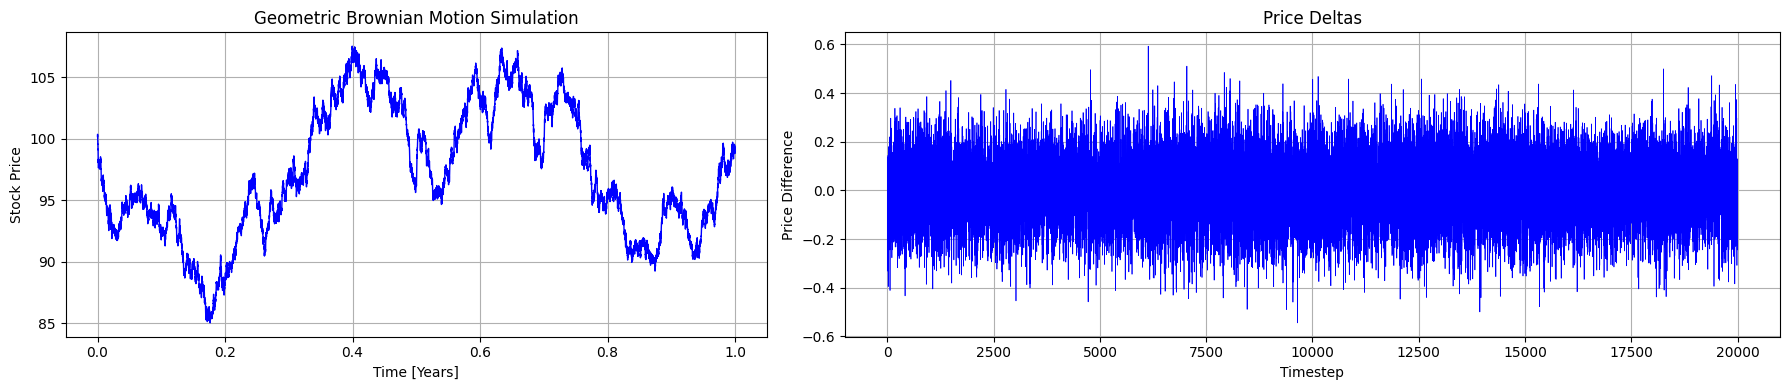

In [107]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4), gridspec_kw={'width_ratios': [1.5, 2]})
axs[0].plot(t, Price_GBM, color='blue', linewidth=1)
axs[0].set_title('Geometric Brownian Motion Simulation')
axs[0].set_xlabel('Time [Years]')
axs[0].set_ylabel('Stock Price')
axs[0].grid('True')

axs[1].plot(Delta_GBM, color='blue', linewidth=0.5)
axs[1].set_title('Price Deltas')
axs[1].set_xlabel('Timestep')
axs[1].set_ylabel('Price Difference')
axs[1].grid('True')
plt.tight_layout()
plt.show()

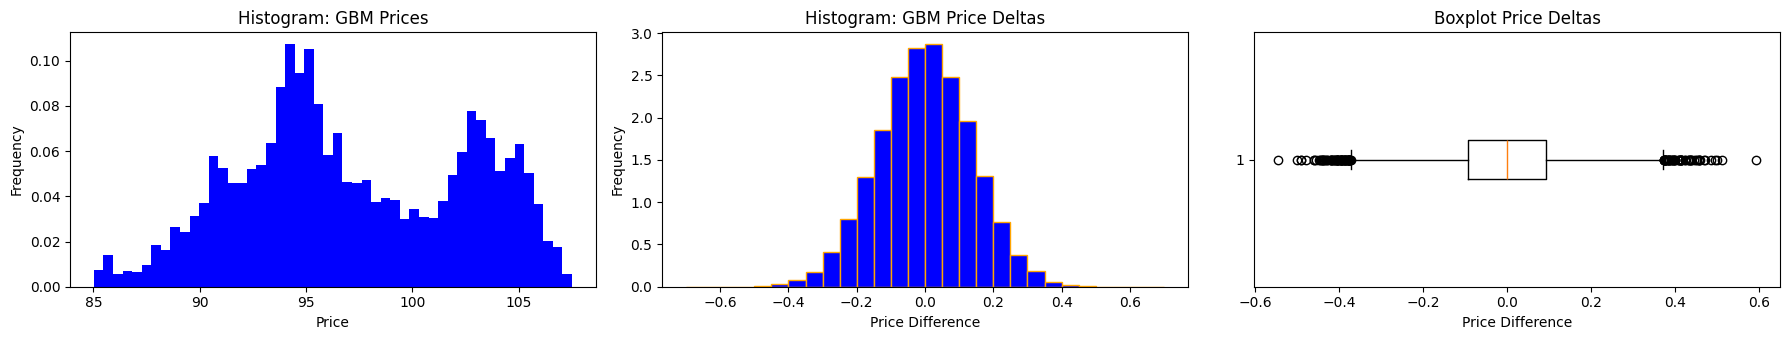

In [108]:
fig, axs = plt.subplots(1, 3, figsize=(18, 3.5))

# Histogram: GBM Prices
axs[0].hist(Price_GBM, bins=50, color='blue', density=True)
axs[0].set_title('Histogram: GBM Prices')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Frequency')

bin_width = 0.05
bins = np.arange(-0.7, 0.7 + bin_width, bin_width)

# Histogram: GBM Price Deltas
axs[1].hist(Delta_GBM, bins=bins, edgecolor='orange', color='blue', density=True)
axs[1].set_title('Histogram: GBM Price Deltas')
axs[1].set_xlabel('Price Difference')
axs[1].set_ylabel('Frequency')

# Boxplot Price Deltas
axs[2].boxplot(Delta_GBM, vert=False)
axs[2].set_title('Boxplot Price Deltas')
axs[2].set_xlabel('Price Difference')
plt.tight_layout()
plt.show()


Discretizing Data and Train-Val-Test Split

In [150]:
data = np.array(Delta_GBM)

# Bin range and Bin width
bin_start = -0.7
bin_stop = 0.7
bin_width = 0.05
num_bins = int((bin_stop - bin_start) / bin_width)  # Calculate number of bins
bin_edges = np.arange(bin_start, bin_stop + bin_width, bin_width)

# Tokenize the data
tokenized_data = np.digitize(data, bins=bin_edges, right=False) - 1

# Clip any deltas below -0.7 to the first bin and above 0.7 to the last bin
tokenized_data = np.clip(tokenized_data, 0, num_bins - 1)

# Train / Test Split
train_data_temp, temp_data = train_test_split(tokenized_data, train_size=0.7, shuffle=False)
val_data_temp, test_data_temp = train_test_split(temp_data, test_size=0.5, shuffle=False)

def prep_data(seq_len, start_indexes, data):
    final_list = []
    for i in start_indexes:
        final_list.append(data[i:i+seq_len])
    return final_list

LSTM Model

In [151]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM Layer
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # Fully Connected Layer
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden=None):
        # A sequence of 50 tokens is passed to the embedding layer and we get the embeddings for each token (dimension: 32)
        embedded = self.embedding(x)                            # Shape: [batch_size, sequence_length, embedding_dim] [1, 50, 32]
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(embedded, hidden)      # Input: 50 tokens, Output: 50 hidden states with dimension 128
        # Apply fully connected layer to each time step
        logits = self.fc(lstm_out)                              # Shape: [batch_size, sequence_length, output_dim]
        
        return logits, hidden                                   # Return predictions for each time step

#### Train setting:

| Train set:                           |     $\approx$ 14'000         |
| ------------------------------------ | ---------------------------- |
| **Sequence Length:**                 | **50**                       |
| Sequences for a full epoch:          | $\approx$ 280                |
| **Batch size:**                      | **32**                       |
| Episode length:                      | 1 Batch or 10 sequences      |


PARAMETERS

In [160]:
seq_len = 50                                                    # Sequence Length
batch_size = 32                                                 # Batch Size
learning_rate = 0.001                                           # Learning Rate Adam Optimizer
num_episodes = int(len(train_data_temp)/(seq_len*batch_size))   # Number of episodes for one Epoch

num_epochs = 500

VALIDATION DATA

In [161]:
n_val_seq = len(val_data_temp) // seq_len
val_data = [val_data_temp[i*seq_len:(i+1)*seq_len] for i in range(n_val_seq)]

In [162]:
ss_model = LSTMModel(vocab_size=num_bins, embedding_dim=32, hidden_dim=64, output_dim=num_bins)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(ss_model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    avg_train_loss = 0
    avg_val_loss = 0

    for episode in range(num_episodes):

        ## ============
        ## TRAINING
        ## ============

        ss_model.train()
        ss_model.zero_grad()

        # Sample the Batch 
        start_train_idx = np.random.choice(range(len(train_data_temp) - seq_len), size=batch_size, replace=True)
        train_data = prep_data(seq_len=seq_len, start_indexes=start_train_idx, data=train_data_temp)
        
        # Create Tensor of Sequence and Target
        sequence_inputs = torch.tensor([seq[:-1] for seq in train_data])    # Remove Last Token
        targets = torch.tensor([seq[1:] for seq in train_data])             # Remove First Token

        # Forward pass: Shape [batch_size, sequence_length - 1, output_dim]
        logits, _ = ss_model(sequence_inputs)

        # [batch_size*sequence_length-1, output_dim/unique Tokens]
        logits = logits.view(-1, logits.size(-1))
        # Flatten targets: [batch_size*sequence_length-1]
        targets = targets.view(-1)

        loss = criterion(logits, targets)          # Loss
        loss.backward()                            # Backward pass
        optimizer.step()                           # Update weights
        avg_train_loss += loss.item()              # Save Loss

        ## ============
        ## VALIDATION
        ## ============
        
        ss_model.eval()
        
        sequence_inputs = torch.tensor([seq[:-1] for seq in val_data])  # Remove Last Token
        targets = torch.tensor([seq[1:] for seq in val_data])
        
        with torch.no_grad():
            logits, _ = ss_model(sequence_inputs)       # Forward Pass
            logits = logits.view(-1, logits.size(-1))   # Flatten Logits
            targets = targets.view(-1)                  # Flatten targets
            loss = criterion(logits, targets)           # Loss
            avg_val_loss += loss.item()                 # Save Loss
    
    epoch_train_loss = avg_train_loss/num_episodes      # Avg Train Loss after Epoch
    epoch_val_loss = avg_val_loss/num_episodes          # Avg Val Loss after Epoch
    train_losses.append(epoch_train_loss)
    val_losses.append(epoch_val_loss)
    
    print(f"Epoch {epoch} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")


Epoch 0 - Train Loss: 3.2434 - Val Loss: 3.2283
Epoch 1 - Train Loss: 3.0806 - Val Loss: 3.0538
Epoch 2 - Train Loss: 2.7793 - Val Loss: 2.7314
Epoch 3 - Train Loss: 2.5575 - Val Loss: 2.5551
Epoch 4 - Train Loss: 2.4968 - Val Loss: 2.5052
Epoch 5 - Train Loss: 2.4820 - Val Loss: 2.4838
Epoch 6 - Train Loss: 2.4698 - Val Loss: 2.4713
Epoch 7 - Train Loss: 2.4659 - Val Loss: 2.4670
Epoch 8 - Train Loss: 2.4577 - Val Loss: 2.4668
Epoch 9 - Train Loss: 2.4716 - Val Loss: 2.4643
Epoch 10 - Train Loss: 2.4644 - Val Loss: 2.4620
Epoch 11 - Train Loss: 2.4597 - Val Loss: 2.4614
Epoch 12 - Train Loss: 2.4629 - Val Loss: 2.4604
Epoch 13 - Train Loss: 2.4666 - Val Loss: 2.4586
Epoch 14 - Train Loss: 2.4799 - Val Loss: 2.4599
Epoch 15 - Train Loss: 2.4484 - Val Loss: 2.4597
Epoch 16 - Train Loss: 2.4607 - Val Loss: 2.4580
Epoch 17 - Train Loss: 2.4549 - Val Loss: 2.4572
Epoch 18 - Train Loss: 2.4659 - Val Loss: 2.4575
Epoch 19 - Train Loss: 2.4419 - Val Loss: 2.4561
Epoch 20 - Train Loss: 2.4590 

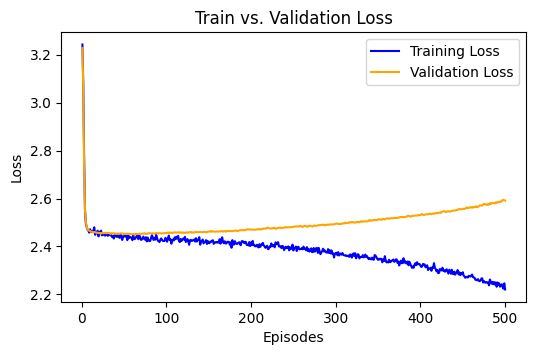

In [163]:
plt.figure(figsize=(6, 3.5))
plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss', color='blue')
plt.plot(range(1, len(val_losses)+1), val_losses, label = 'Validation Loss', color='orange')
plt.title('Train vs. Validation Loss')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.legend()
plt.show()